In [1]:
# Import libraries
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# NLTK VADER for sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer

finviz_url = 'https://finviz.com/quote.ashx?t='
yahoo_url = 'https://in.finance.yahoo.com/quote/' #IBN  /?p=  IBN'
reuters_url = 'https://in.reuters.com/companies/' #BJFN.NS  /news'
investing_url = 'https://in.investing.com/search/?q=' #BJFN.NS  &tab=news

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
news_tables = {}
tickers = ['AMZN','GOOG','TSLA','AAPL']

for ticker in tickers:
    url = finviz_url + ticker
    #url_yah = yahoo_url + ticker + '/?p=' + ticker
    #print(url)
    req = Request(url,headers={'user-agent': 'Mozilla/5.0'}) 
    response = urlopen(req)    
    # Read the contents of the file into 'html'
    html = BeautifulSoup(response)
    # Find 'news-table' in the Soup and load it into 'news_table'
    news_table = html.find(id='news-table')
    # Add the table to our dictionary
    news_tables[ticker] = news_table
#print(news_table)

In [3]:
# Read one single day of headlines for 'AMZN' 
amzn = news_tables['AMZN']
# Get all the table rows tagged in HTML with <tr> into 'amzn_tr'
amzn_tr = amzn.findAll('tr')

for i, table_row in enumerate(amzn_tr):
    # Read the text of the element 'a' into 'link_text'
    a_text = table_row.a.text
    # Read the text of the element 'td' into 'data_text'
    td_text = table_row.td.text
    # Print the contents of 'link_text' and 'data_text' 
    print(a_text)
    print(td_text)
    # Exit after printing 4 rows of data
    if i == 3:
        break

Amazon Clinches Election Win Over Union as Count Continues
Apr-09-21 11:32AM  
Amazon vote counts not in favor of forming union
11:23AM  
CrowdStrike Stock: Partnership With Amazon Seen As Growth Driver
11:22AM  
Amazon's stock rises toward 7-week high after workers vote against forming a union
11:10AM  


In [4]:
parsed_news = []

# Iterate through the news
for file_name, news_table in news_tables.items():
    # Iterate through all tr tags in 'news_table'
    for x in news_table.findAll('tr'):
        # read the text from each tr tag into text
        # get text from a only
        text = x.a.get_text() 
        # splite text in the td tag into a list 
        date_scrape = x.td.text.split()
        # if the length of 'date_scrape' is 1, load 'time' as the only element

        if len(date_scrape) == 1:
            time = date_scrape[0]
            
        # else load 'date' as the 1st element and 'time' as the second    
        else:
            date = date_scrape[0]
            time = date_scrape[1]
        # Extract the ticker from the file name, get the string up to the 1st '_'  
        ticker = file_name.split('_')[0]
        
        # Append ticker, date, time and headline as a list to the 'parsed_news' list
        parsed_news.append([ticker, date, time, text])
        
parsed_news

[['AMZN',
  'Apr-09-21',
  '11:32AM',
  'Amazon Clinches Election Win Over Union as Count Continues'],
 ['AMZN',
  'Apr-09-21',
  '11:23AM',
  'Amazon vote counts not in favor of forming union'],
 ['AMZN',
  'Apr-09-21',
  '11:22AM',
  'CrowdStrike Stock: Partnership With Amazon Seen As Growth Driver'],
 ['AMZN',
  'Apr-09-21',
  '11:10AM',
  "Amazon's stock rises toward 7-week high after workers vote against forming a union"],
 ['AMZN',
  'Apr-09-21',
  '10:16AM',
  'What Best Buys new membership program means for shoppers'],
 ['AMZN',
  'Apr-09-21',
  '10:00AM',
  "First 5 Recommendations for our April Fool's Portfolio!"],
 ['AMZN',
  'Apr-09-21',
  '09:58AM',
  'COVID-19 is no longer markets greatest risk: strategist'],
 ['AMZN',
  'Apr-09-21',
  '09:45AM',
  'It is time to kick counterfeit goods off Amazon, Facebook Marketplace and other e-commerce sites'],
 ['AMZN',
  'Apr-09-21',
  '09:05AM',
  'Amazon workers appear to overwhelmingly vote against union in Alabama, union claims i

In [5]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [6]:
# Instantiate the sentiment intensity analyzer
vader = SentimentIntensityAnalyzer()

# Set column names
columns = ['ticker', 'date', 'time', 'headline']

# Convert the parsed_news list into a DataFrame called 'parsed_and_scored_news'
parsed_and_scored_news = pd.DataFrame(parsed_news, columns=columns)

# Iterate through the headlines and get the polarity scores using vader
scores = parsed_and_scored_news['headline'].apply(vader.polarity_scores).tolist()

# Convert the 'scores' list of dicts into a DataFrame
scores_df = pd.DataFrame(scores)

# Join the DataFrames of the news and the list of dicts
parsed_and_scored_news = parsed_and_scored_news.join(scores_df, rsuffix='_right')

# Convert the date column from string to datetime
parsed_and_scored_news['date'] = pd.to_datetime(parsed_and_scored_news.date).dt.date

parsed_and_scored_news.head()

,ticker,date,time,headline,neg,neu,pos,compound
0,AMZN,2021-04-09,11:32AM,Amazon Clinches Election Win Over Union as Cou...,0.000,0.560,0.440,0.6705
1,AMZN,2021-04-09,11:23AM,Amazon vote counts not in favor of forming union,0.206,0.639,0.155,-0.1426
2,AMZN,2021-04-09,11:22AM,CrowdStrike Stock: Partnership With Amazon See...,0.000,0.619,0.381,0.5106
3,AMZN,2021-04-09,11:10AM,Amazon's stock rises toward 7-week high after ...,0.000,1.000,0.000,0.0000
4,AMZN,2021-04-09,10:16AM,What Best Buys new membership program means fo...,0.000,0.656,0.344,0.6369


In [7]:
parsed_and_scored_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ticker    400 non-null    object 
 1   date      400 non-null    object 
 2   time      400 non-null    object 
 3   headline  400 non-null    object 
 4   neg       400 non-null    float64
 5   neu       400 non-null    float64
 6   pos       400 non-null    float64
 7   compound  400 non-null    float64
dtypes: float64(4), object(4)
memory usage: 25.1+ KB


In [8]:
parsed_and_scored_news.sort_values(by=['date','time'], inplace=True)
parsed_and_scored_news.to_excel("ticker_sentiment.xlsx")  

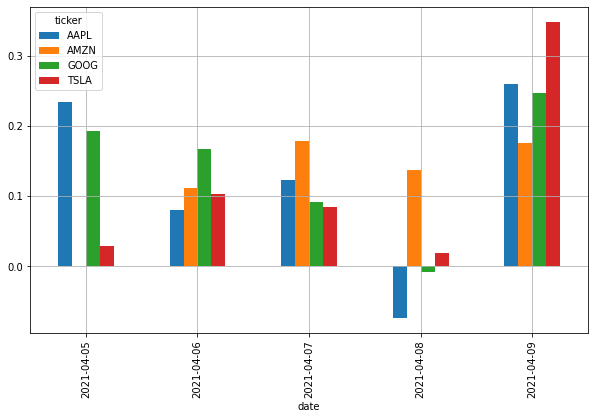

In [9]:
plt.rcParams['figure.figsize'] = [10, 6]

# Group by date and ticker columns from scored_news and calculate the mean
mean_scores = parsed_and_scored_news.groupby(['ticker','date']).mean()

# Unstack the column ticker
mean_scores = mean_scores.unstack()

# Get the cross-section of compound in the 'columns' axis
mean_scores = mean_scores.xs('compound', axis="columns").transpose()

# Plot a bar chart with pandas
mean_scores.plot(kind = 'bar')
plt.grid()

In [10]:
# Grouped sentiment scores averaged by date.

import datetime 
dailyavgsent=parsed_and_scored_news.groupby(['ticker','date']).mean()
print(dailyavgsent)
#print(list(dailyavgsent.index))

                        neg       neu       pos  compound
ticker date                                              
AAPL   2021-04-05  0.000000  0.847750  0.152250  0.233575
       2021-04-06  0.067947  0.824789  0.107211  0.080842
       2021-04-07  0.053182  0.833091  0.113682  0.123595
       2021-04-08  0.100556  0.843472  0.055972 -0.073922
       2021-04-09  0.024316  0.769474  0.206211  0.259632
AMZN   2021-04-06  0.084333  0.766500  0.149000  0.111250
       2021-04-07  0.046179  0.807679  0.146107  0.178536
       2021-04-08  0.050051  0.787000  0.163051  0.137485
       2021-04-09  0.056333  0.750333  0.193407  0.175304
GOOG   2021-04-05  0.078923  0.751769  0.169308  0.192746
       2021-04-06  0.043385  0.811923  0.144615  0.166681
       2021-04-07  0.082765  0.803294  0.113941  0.091224
       2021-04-08  0.079300  0.847450  0.073250 -0.008155
       2021-04-09  0.029000  0.767727  0.203273  0.246809
TSLA   2021-04-05  0.070909  0.829227  0.099818  0.028268
       2021-04

In [11]:
# Filter by a particular desired date
from datetime import date
date_entry = "2021-04-08"
year, month, day = map(int, date_entry.split('-'))
date1 = datetime.date(year, month, day)
print(date1)

extract=dailyavgsent.loc[dailyavgsent.index.get_level_values(level = 'date') == date1]
print(extract)
extracted=extract['compound'].to_numpy()
extracted

2021-04-08
                        neg       neu       pos  compound
ticker date                                              
AAPL   2021-04-08  0.100556  0.843472  0.055972 -0.073922
AMZN   2021-04-08  0.050051  0.787000  0.163051  0.137485
GOOG   2021-04-08  0.079300  0.847450  0.073250 -0.008155
TSLA   2021-04-08  0.047875  0.894500  0.057625  0.019681


array([-0.07392222,  0.13748462, -0.008155  ,  0.01968125])

In [12]:
cov_sent=extract['compound']
cov_sent

ticker  date      
AAPL    2021-04-08   -0.073922
AMZN    2021-04-08    0.137485
GOOG    2021-04-08   -0.008155
TSLA    2021-04-08    0.019681
Name: compound, dtype: float64

In [13]:
# Extraction of weights from sentiment scores and standardization using softmax function (concept in deep learning)

#manual softmax
#def softmax(x):
#   e_x = np.exp(x - np.max(x))
#   return e_x / e_x.sum(axis=0)

# Weights

from scipy.special import softmax
sent_weights=softmax(extracted)
print(sent_weights)

[0.22719439 0.28067932 0.24263863 0.24948766]


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from pandas_datareader import data as pdr

# import data
def get_data(stocks, start, end):
    stockData = pdr.get_data_yahoo(stocks, start, end)
    stockData = stockData['Close']
    returns = stockData.pct_change()
    meanReturns = returns.mean()
    covMatrix = returns.cov()
    return meanReturns, covMatrix

#stockList = ['CBA', 'BHP', 'TLS', 'NAB', 'WBC', 'STO']
#stocks = [stock + '.AX' for stock in tickers]
endDate = dt.datetime.today()
startDate = endDate - dt.timedelta(days=300)

meanReturns, covMatrix = get_data(tickers, startDate, endDate)

#print(covMatrix)

weights = np.random.random(len(meanReturns))
weights /= np.sum(weights)
print(weights)

[0.24459951 0.39156129 0.19594286 0.16789634]


In [28]:
# Monte Carlo Method

def MC(weights):
  global initialPortfolio
  
  mc_sims = 10000 # number of simulations
  T = 30 #timeframe in days

  meanM = np.full(shape=(T, len(weights)), fill_value=meanReturns)
  meanM = meanM.T

  portfolio_sims = np.full(shape=(T, mc_sims), fill_value=0.0)

  initialPortfolio = 100

  for m in range(0, mc_sims):
      Z = np.random.normal(size=(T, len(weights)))#uncorrelated RV's
      L = np.linalg.cholesky(covMatrix) #Cholesky decomposition to Lower Triangular Matrix
      dailyReturns = meanM + np.inner(L, Z) #Correlated daily returns for individual stocks
      portfolio_sims[:,m] = np.cumprod(np.inner(weights, dailyReturns.T)+1)*initialPortfolio
  
  return portfolio_sims

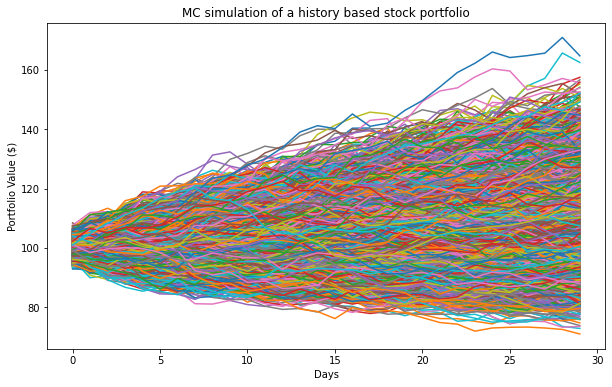

In [29]:
portfolio_sims_hist=MC(weights)

plt.plot(portfolio_sims_hist)
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Days')
plt.title('MC simulation of a history based stock portfolio')
plt.show()

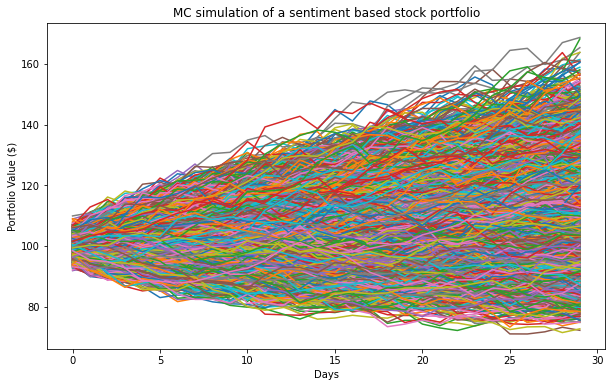

In [30]:
portfolio_sims_sent=MC(sent_weights)

plt.plot(portfolio_sims_sent)
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Days')
plt.title('MC simulation of a sentiment based stock portfolio')
plt.show()

In [31]:
sim_val_hist=portfolio_sims_hist.copy()
sim_val_sent=portfolio_sims_sent.copy()

In [32]:
frame=len(portfolio_sims_hist[0])
sims=len(portfolio_sims_hist)

def call(c):
  for i in range(sims):
    for j in range(frame):
      c[i][j]= c[i][j]-initialPortfolio

      if c[i][j]<0:
        c[i][j]= 0
      else:
        c[i][j]=c[i][j]
  return c

call_hist=call(sim_val_hist)
call_sent=call(sim_val_sent)
#print(call_hist, call_sent)

In [33]:
sim_val_hist=portfolio_sims_hist.copy()
sim_val_sent=portfolio_sims_sent.copy()

In [34]:
def put(p):
  for i in range(sims):
    for j in range(frame):
      p[i][j]= initialPortfolio-p[i][j]

      if p[i][j]<0:
        p[i][j]= 0
      else:
        p[i][j]=p[i][j]
  return p
put_hist=put(sim_val_hist)
put_sent=put(sim_val_sent)
#print(put_hist, put_sent)

In [35]:
payoff_call_hist=np.mean(call_hist)
payoff_call_sent=np.mean(call_sent)
payoff_put_hist=np.mean(put_hist)
payoff_put_sent=np.mean(put_sent)

In [36]:
print("Call historical payoff:",payoff_call_hist, "\nCall sentiment payoff:", payoff_call_sent, "\nPut historical payoff:", payoff_put_hist,
      "\n Put sentiment payoff:", payoff_put_sent)

Call historical payoff: 6.18014586368581 
Call sentiment payoff: 6.737144323833737 
Put historical payoff: 1.3008750964061289 
 Put sentiment payoff: 1.3762314166788072


In [37]:
def mcVaR(returns, alpha=5):
    """ Input: pandas series of returns
        Output: percentile on return distribution to a given confidence level alpha
    """
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)
    else:
        raise TypeError("Expected a pandas data series.")

def mcCVaR(returns, alpha=5):
    """ Input: pandas series of returns
        Output: CVaR or Expected Shortfall to a given confidence level alpha
    """
    if isinstance(returns, pd.Series):
        belowVaR = returns <= mcVaR(returns, alpha=alpha)
        return returns[belowVaR].mean()
    else:
        raise TypeError("Expected a pandas data series.")

In [38]:
portResults = pd.Series(portfolio_sims_hist[-1,:])

VaR_hist = initialPortfolio - mcVaR(portResults, alpha=5)
CVaR_hist = initialPortfolio - mcCVaR(portResults, alpha=5)

print('VaR ${}'.format(round(VaR_hist,2)))
print('CVaR ${}'.format(round(CVaR_hist,2)))

VaR $9.17
CVaR $13.38


In [39]:
portResults = pd.Series(portfolio_sims_sent[-1,:])

VaR_sent = initialPortfolio - mcVaR(portResults, alpha=5)
CVaR_sent = initialPortfolio - mcCVaR(portResults, alpha=5)

print('VaR ${}'.format(round(VaR_sent,2)))
print('CVaR ${}'.format(round(CVaR_sent,2)))

VaR $9.78
CVaR $14.09
